In [13]:
import pandas as pd #for manipulating the csv data
import numpy as np #for mathematical calculation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import sys, threading
sys.setrecursionlimit(10**7) # max depth of recursion
threading.stack_size(2**27)  # new thread will get stack of such size

134217728

In [14]:
import math
from xml.dom import minidom
from xml.etree import ElementTree as ET

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y


class C45(BaseEstimator, ClassifierMixin):

    def __init__(self, attrNames=None):
        if attrNames is not None:
            attrNames = [''.join(i for i in x if i.isalnum()).replace(' ', '_') for x in attrNames]
        self.attrNames = attrNames

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.resultType = type(y[0])
        if self.attrNames is None:
            self.attrNames = [f'attr{x}' for x in range(len(self.X_[0]))]

        assert(len(self.attrNames) == len(self.X_[0]))

        data = [[] for i in range(len(self.attrNames))]
        categories = []

        for i in range(len(self.X_)):
            categories.append(str(self.y_[i]))
            for j in range(len(self.attrNames)):
                data[j].append(self.X_[i][j])
        root = ET.Element('DecisionTree')
        grow_tree(data,categories,root,self.attrNames)
        self.tree_ = ET.tostring(root, encoding="unicode")
        return self

    def predict(self, X):
        check_is_fitted(self, ['tree_', 'resultType', 'attrNames'])
        X = check_array(X)
        dom = minidom.parseString(self.tree_)
        root = dom.childNodes[0]
        prediction = []
        for i in range(len(X)):
            answerlist = decision(root,X[i],self.attrNames,1)
            answerlist = sorted(answerlist.items(), key=lambda x:x[1], reverse = True )
            answer = answerlist[0][0]
            prediction.append((self.resultType)(answer))
        return prediction

    def printTree(self):
        check_is_fitted(self, ['tree_'])
        dom = minidom.parseString(self.tree_)
        print(dom.toprettyxml(newl="\r\n"))
import math
from xml.etree import ElementTree as ET


def prettify(elem, level=0):
    i = "\n" + level*"  "
    if len(elem):
        if not elem.text or not elem.text.strip():
            elem.text = i + "  "
        for e in elem:
            prettify(e, level+1)
        if not e.tail or not e.tail.strip():
            e.tail = i
    if level and (not elem.tail or not elem.tail.strip()):
        elem.tail = i
    return elem

def isnum(attr):
    for x in set(attr):
        if not x=="?":
            try:
                x=float(x)
                return isinstance(x,float)
            except ValueError:
                return False
    return True

def entropy(x):
    ent=0
    for k in set(x):
        p_i=float(x.count(k))/len(x)
        ent=ent-p_i* math.log(p_i,2)
    return ent

def gain_ratio(category,attr):
    s=0
    cat=[]
    att=[]
    for i in range(len(attr)):
        if not attr[i]=="?":
            cat.append(category[i])
            att.append(attr[i])
    for i in set(att):      
        p_i=float(att.count(i))/len(att)
        cat_i=[]
        for j in range(len(cat)):
            if att[j]==i:
                cat_i.append(cat[j])
        s=s+p_i*entropy(cat_i)
    gain=entropy(cat)-s
    ent_att=entropy(att)
    if ent_att==0:
        return 0
    else:
        return gain/ent_att

def gain(category,attr):
    cats=[]
    for i in range(len(attr)):
        if not attr[i]=="?":
            cats.append([float(attr[i]),category[i]])
    cats=sorted(cats, key=lambda x:x[0])
    
    cat=[cats[i][1] for i in range(len(cats))]
    att=[cats[i][0] for i in range(len(cats))]
    if len(set(att))==1:
        return 0
    else:
        gains=[]
        div_point=[]
        for i in range(1,len(cat)):
            if not att[i]==att[i-1]:
                gains.append(entropy(cat[:i])*float(i)/len(cat)+entropy(cat[i:])*(1-float(i)/len(cat)))
                div_point.append(i)
        gain=entropy(cat)-min(gains)
    
        p_1=float(div_point[gains.index(min(gains))])/len(cat)
        ent_attr= -p_1*math.log(p_1,2)-(1-p_1)*math.log((1-p_1),2)
        return gain/ent_attr

def division_point(category,attr):
    cats=[]
    for i in range(len(attr)):
        if not attr[i]=="?":
            cats.append([float(attr[i]),category[i]])
    cats=sorted(cats, key=lambda x:x[0])
    
    cat=[cats[i][1] for i in range(len(cats))]
    att=[cats[i][0] for i in range(len(cats))]
    gains=[]
    div_point=[]
    for i in range(1,len(cat)):
        if not att[i]==att[i-1]:
            gains.append(entropy(cat[:i])*float(i)/len(cat)+entropy(cat[i:])*(1-float(i)/len(cat)))
            div_point.append(i)
    return att[div_point[gains.index(min(gains))]]

def grow_tree(data,category,parent,attrs_names):
    if len(set(category))>1:
        
        division=[]
        for i in range(len(data)):
            if set(data[i])==set("?"):
                division.append(0)
            else:
                if (isnum(data[i])):
                    division.append(gain(category,data[i]))           
                else:
                    division.append(gain_ratio(category,data[i]))
        if max(division)==0:
            num_max=0
            for cat in set(category):
                num_cat=category.count(cat)
                if num_cat>num_max:
                    num_max=num_cat
                    most_cat=cat                
            parent.text=most_cat
        else:
            index_selected=division.index(max(division))
            name_selected=str(attrs_names[index_selected])
            if isnum(data[index_selected]):
                div_point=division_point(category,data[index_selected])
                r_son_data=[[] for i in range(len(data))]
                r_son_category=[]
                l_son_data=[[] for i in range(len(data))]
                l_son_category=[]
                for i in range(len(category)):
                    if not data[index_selected][i]=="?":
                        if float(data[index_selected][i])<float(div_point):
                            l_son_category.append(category[i])
                            for j in range(len(data)):
                                l_son_data[j].append(data[j][i])     
                        else:
                            r_son_category.append(category[i])
                            for j in range(len(data)):
                                r_son_data[j].append(data[j][i])  
                if len(l_son_category)>0 and len(r_son_category)>0:
                    p_l=float(len(l_son_category))/(len(data[index_selected])-data[index_selected].count("?"))
                    son=ET.SubElement(parent,name_selected,{'value':str(div_point),"flag":"l","p":str(round(p_l,3))})
                    grow_tree(l_son_data,l_son_category,son,attrs_names)
                    son=ET.SubElement(parent,name_selected,{'value':str(div_point),"flag":"r","p":str(round(1-p_l,3))})
                    grow_tree(r_son_data,r_son_category,son,attrs_names)
                else:
                    num_max=0
                    for cat in set(category):
                        num_cat=category.count(cat)
                        if num_cat>num_max:
                            num_max=num_cat
                            most_cat=cat                
                    parent.text=most_cat
            else:
                for k in set(data[index_selected]):
                    if not k=="?":
                        son_data=[[] for i in range(len(data))]
                        son_category=[]
                        for i in range(len(category)):
                            if data[index_selected][i]==k:
                                son_category.append(category[i])
                                for j in range(len(data)):
                                    son_data[j].append(data[j][i])
                        son=ET.SubElement(parent,name_selected,{'value':k,"flag":"m",'p':str(round(float(len(son_category))/(len(data[index_selected])-data[index_selected].count("?")),3))}) 
                        grow_tree(son_data,son_category,son,attrs_names)   
    else:
        parent.text=category[0]

def add(d1,d2):
    d=d1
    for i in d2:
        if d.has_key(i):
            d[i]=d[i]+d2[i]
        else:
            d[i]=d2[i]
    return d

def decision(root,obs,attrs_names,p):
    if root.hasChildNodes():
        att_name=root.firstChild.nodeName
        if att_name=="#text":
            
            return decision(root.firstChild,obs,attrs_names,p)  
        else:
            att=obs[attrs_names.index(att_name)]
            if att=="?":
                d={}
                for child in root.childNodes:                    
                    d=add(d,decision(child,obs,attrs_names,p*float(child.getAttribute("p"))))
                return d
            else:
                for child in root.childNodes:
                    if child.getAttribute("flag")=="m" and child.getAttribute("value")==att or \
                        child.getAttribute("flag")=="l" and float(att)<float(child.getAttribute("value")) or \
                        child.getAttribute("flag")=="r" and float(att)>=float(child.getAttribute("value")):
                        return decision(child,obs,attrs_names,p)    
    else:
        return {root.nodeValue:p}


In [15]:
train_data_m = pd.read_csv("datadiskritfinal.csv",delimiter=';')
print(train_data_m)

      gender  age  hypertension  heart_disease ever_married      work_type  \
0       Male   42             0              1          Yes        Private   
1     Female   42             0              0          Yes  Self-employed   
2       Male   42             0              1          Yes        Private   
3     Female   42             0              0          Yes        Private   
4     Female   42             1              0          Yes  Self-employed   
...      ...  ...           ...            ...          ...            ...   
5105  Female   42             1              0          Yes        Private   
5106  Female   42             0              0          Yes  Self-employed   
5107  Female   40             0              0          Yes  Self-employed   
5108    Male   42             0              0          Yes        Private   
5109  Female   42             0              0          Yes       Govt_job   

     Residence_type  bmi  avg_glucose_level   smoking_status  s

In [16]:
from sklearn.preprocessing import LabelEncoder
dataset = train_data_m

le= LabelEncoder()
codex= dataset
codex["gender"] = le.fit_transform(codex["gender"])
codex["ever_married"] = le.fit_transform(codex["ever_married"])
codex["work_type"] = le.fit_transform(codex["work_type"])
codex["Residence_type"] = le.fit_transform(codex["Residence_type"])
codex["smoking_status"] = le.fit_transform(codex["smoking_status"])

x_data=codex.loc[:, codex.columns != "stroke" ].to_numpy()
y_data=codex["stroke"].to_numpy()
print(x_data[0])
print(len(np.where(y_data == 1)[0]))
print(len(np.where(y_data == 0)[0]))

[  1  42   0   1   1   2   1  52 162   1]
249
4861


In [17]:
# random

In [18]:
print(dataset)

      gender  age  hypertension  heart_disease  ever_married  work_type  \
0          1   42             0              1             1          2   
1          0   42             0              0             1          3   
2          1   42             0              1             1          2   
3          0   42             0              0             1          2   
4          0   42             1              0             1          3   
...      ...  ...           ...            ...           ...        ...   
5105       0   42             1              0             1          2   
5106       0   42             0              0             1          3   
5107       0   40             0              0             1          3   
5108       1   42             0              0             1          2   
5109       0   42             0              0             1          0   

      Residence_type  bmi  avg_glucose_level  smoking_status  stroke  
0                  1   52   

In [21]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
c=1
ak=[]
aks=[]
sm = SMOTE(random_state=42)
skf= StratifiedKFold(n_splits=10)
for train_id, test_id in skf.split(x_data, y_data):
    print("fold ke-",c)
    print(len(train_id))
    print(len(test_id))
    x_train, y_train= x_data[train_id], y_data[train_id]
    x_res, y_res = sm.fit_resample(x_train, y_train)
    print(np.bincount(y_res))
    x_test, y_test = x_data[test_id], y_data[test_id]

    tree2 = C45(attrNames=["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","bmi","avg_glucose_level","smoking_status"])

    tree = C45(attrNames=["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","bmi","avg_glucose_level","smoking_status"])
    tree.fit(x_res,y_res)
    tree2.fit(x_train,y_train)
    # tree.printTree()
    y_pred = tree.predict(x_test)
    print(y_pred)

    y_pred2 = tree2.predict(x_test)
    print(y_pred2)
    matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
    print('Confusion matrix : \n',matrix)
    print("")

    # outcome values order in sklearn
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred,labels=[1,0]).reshape(-1)
    print("True positive :", tp)
    print("False negative :", fn)
    print("False positive :", fp)
    print("True negative :", tn)
    print("")

    # classification report for precision, recall f1-score and accuracy
    matrix = classification_report(y_test, y_pred,labels=[1,0])
    print('Classification report : \n',matrix)
    print("")

    #akurasi
    accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
    print("Akurasi fold ini adalah :", accuracy, " %")
    accuracy2 = round(((tp+tn)/(tp+fn+fp+tn)*100), 2)
    aks.append(accuracy2)
    print("Akurasi fold ini adalah :", accuracy2, " %")
    print("===========================================================")
    print("===========================================================")
    print("tanpa smote")
    matrix2 = confusion_matrix(y_test, y_pred2, labels=[1,0])
    print('Confusion matrix : \n',matrix2)
    print("")

    # outcome values order in sklearn
    tp2, fn2, fp2, tn2 = confusion_matrix(y_test, y_pred2,labels=[1,0]).reshape(-1)
    print("True positive :", tp2)
    print("False negative :", fn2)
    print("False positive :", fp2)
    print("True negative :", tn2)
    print("")

    # classification report for precision, recall f1-score and accuracy
    matrix2 = classification_report(y_test, y_pred2,labels=[1,0])
    print('Classification report : \n',matrix2)
    print("")

    #akurasi
    accuracy3 = round(accuracy_score(y_test, y_pred2)*100, 2)
    print("Akurasi fold ini adalah :", accuracy3, " %")
    accuracy4 = round(((tp2+tn2)/(tp2+fn2+fp2+tn2)*100), 2)
    ak.append(accuracy4)
    print("Akurasi fold ini adalah :", accuracy4, " %")
    print("===========================================================")
    
    # print(len(x_train))
    # print(len(x_test))
    # print("jumlah label train positif",len(np.where(y_train == 1)))
    # print("jumlah label train negatif",len(np.where(y_train == 0)))
    c+=1


fold ke- 1
4599
511
[4375 4375]
[1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0

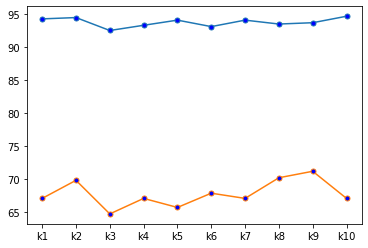

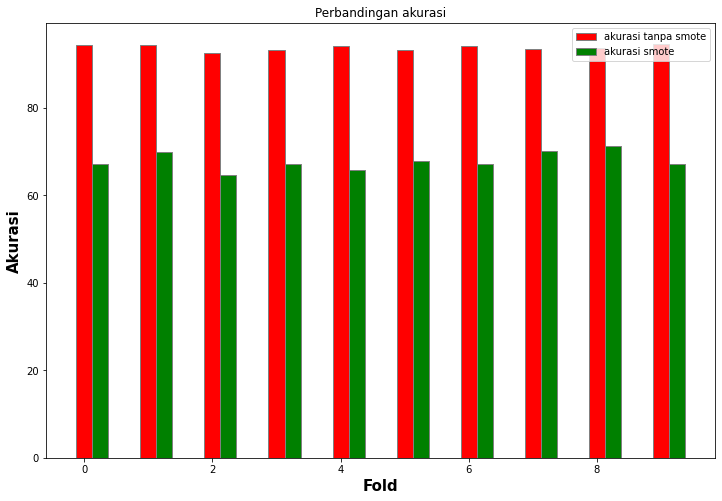

In [20]:
import matplotlib.pyplot as plt

k = ["k"+str(i+1) for i in range(10)]
# line 1 points
# plotting the line 1 points
plt.plot(k, ak,aks, label = "c45", marker='o', markerfacecolor='blue', markersize=5)

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(ak))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, ak, color ='r', width = barWidth,
        edgecolor ='grey', label ='akurasi tanpa smote')
plt.bar(br2, aks, color ='g', width = barWidth,
        edgecolor ='grey', label ='akurasi smote')

# Adding Xticks
plt.xlabel('tingkat akurasi', fontweight ='bold', fontsize = 15)
plt.ylabel('fold ke', fontweight ='bold', fontsize = 15)


# naming the x axis
plt.xlabel('Fold')
# naming the y axis
plt.ylabel('Akurasi')
# giving a title to my graph
plt.title('Perbandingan akurasi')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()